In [16]:
import os
import numpy as np 
import pandas as pd 
import joblib

from datetime import datetime 
from pathlib import Path
from Preprocessing_functions import *
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:

ticker = "SPY"

# LOAD DF FOR MODEL BUILDING 
FILE_PATH = f"Data/{ticker}/df/"
print("DataFrames for model building: ", os.listdir(FILE_PATH))
idx = 0 if len(os.listdir(FILE_PATH)) < 3 else int(input("Select file index: "))
DF_NAME = os.listdir(FILE_PATH)[idx] 
FILE_PATH_NAME = FILE_PATH + DF_NAME

df_model = pd.read_parquet(FILE_PATH_NAME)
df_model = format_idx_date(df_model)
df_model.head()

DataFrames for model building:  ['df_SPY_k3_202402012133.parquet', 'Junk']


,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-15,0,1.363875,1.293933,0.380295,-0.192341,-0.070909,-1.483421,1.553229,0.0,176613900,...,-1.79,-2.56,-3.34,-3.17,-4.20,1.12,5.16,1.69,7.28,16.50
2015-01-16,1,0.112333,-1.436680,-0.124004,-1.531276,-1.550755,-0.093170,1.618820,0.0,211879600,...,-0.23,-0.50,-1.28,-1.85,-2.96,0.47,4.47,2.98,8.67,17.21
2015-01-20,2,1.103176,0.168379,0.384683,-0.156767,-0.945224,-0.324638,1.257971,0.0,130991100,...,0.60,-0.01,-0.29,0.17,-3.06,-1.74,5.44,3.64,9.06,17.61
2015-01-21,1,0.274116,-0.787356,-0.279167,-1.073137,-1.064390,-0.282747,1.332949,0.0,122942700,...,2.04,1.11,0.49,1.64,-2.70,-1.66,4.76,4.15,9.41,16.66
2015-01-22,1,0.812306,-1.036986,0.445576,-1.111879,-1.864436,-0.074070,1.903025,0.0,174356000,...,2.22,3.56,2.61,1.88,-0.72,-0.66,5.50,7.83,12.01,16.95


In [19]:
df_model = df_model.sort_index(ascending = False)
df_model.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-01,1,0.171265,-0.538555,0.362409,-0.744898,-0.711038,-0.204817,0.909389,0.0,59327438,...,-0.82,-0.03,-0.16,2.26,2.24,3.94,12.54,10.10,19.31,21.15
2024-01-31,0,1.178830,1.174737,-0.462425,-0.094143,-0.004142,-1.267686,1.271776,0.0,126011100,...,-0.93,-1.06,-0.52,2.24,1.90,2.16,12.55,9.15,18.65,18.42
2024-01-30,2,0.091732,-0.067270,-0.144523,-0.216080,-0.159148,-0.148489,0.307148,0.0,58618400,...,0.59,1.13,1.24,3.36,3.43,3.28,16.61,10.22,20.46,20.77
2024-01-29,1,0.114818,-0.725811,0.065653,-0.756566,-0.841595,-0.030524,0.864841,0.0,61322800,...,1.21,1.32,1.62,3.06,4.99,3.06,17.95,9.83,20.34,20.81
2024-01-26,2,0.215345,0.036916,-0.090158,-0.313788,-0.178814,-0.349607,0.527478,0.0,76606300,...,0.53,0.82,1.03,2.32,4.31,2.29,17.76,9.92,19.96,21.27


In [20]:
cols = list(df_model.columns)
model_feat = pd.DataFrame(cols)
df_model = min_max_scaling(df_model)
df_model.columns = cols
df_model.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-01,1,0.029610,0.407241,0.655745,0.885707,0.915083,0.970559,0.094273,0.0,0.080204,...,0.395427,0.542258,0.504104,0.607033,0.542382,0.646134,0.610603,0.458155,0.477058,0.442941
2024-01-31,0,0.203809,0.571033,0.605724,0.985555,0.999505,0.817779,0.137757,0.0,0.217139,...,0.391728,0.509032,0.493915,0.606557,0.536171,0.613208,0.610746,0.445413,0.469813,0.414307
2024-01-30,2,0.015860,0.452296,0.625003,0.966846,0.980993,0.978656,0.022009,0.0,0.078748,...,0.442838,0.579677,0.543731,0.633167,0.564121,0.633925,0.668763,0.459764,0.489682,0.438955
2024-01-29,1,0.019851,0.389339,0.637749,0.883916,0.899491,0.995612,0.088928,0.0,0.084302,...,0.463685,0.585806,0.554486,0.626039,0.592620,0.629856,0.687911,0.454533,0.488364,0.439375
2024-01-26,2,0.037231,0.462256,0.628300,0.951854,0.978645,0.949746,0.048447,0.0,0.115686,...,0.440820,0.569677,0.537787,0.608458,0.580197,0.615612,0.685196,0.455740,0.484193,0.444200


#### Make sure to shift the target variable by to predict future days ####

In [ ]:
#### TO SHIFT THE TARGET 
df_model['labels'] = df_model['labels'].shift(1)
df_model = df_model.dropna()
df_model.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-31,1.0,0.203809,0.571033,0.605724,0.985555,0.999505,0.817779,0.137757,0.0,0.217139,...,0.391728,0.509032,0.493915,0.606557,0.536171,0.613208,0.610746,0.445413,0.469813,0.414307
2024-01-30,0.0,0.015860,0.452296,0.625003,0.966846,0.980993,0.978656,0.022009,0.0,0.078748,...,0.442838,0.579677,0.543731,0.633167,0.564121,0.633925,0.668763,0.459764,0.489682,0.438955
2024-01-29,2.0,0.019851,0.389339,0.637749,0.883916,0.899491,0.995612,0.088928,0.0,0.084302,...,0.463685,0.585806,0.554486,0.626039,0.592620,0.629856,0.687911,0.454533,0.488364,0.439375
2024-01-26,1.0,0.037231,0.462256,0.628300,0.951854,0.978645,0.949746,0.048447,0.0,0.115686,...,0.440820,0.569677,0.537787,0.608458,0.580197,0.615612,0.685196,0.455740,0.484193,0.444200
2024-01-25,2.0,0.077655,0.449904,0.661129,0.977028,0.935045,0.991758,0.056907,0.0,0.107305,...,0.454943,0.580645,0.577130,0.610596,0.576361,0.621347,0.707488,0.450912,0.480022,0.448710


In [22]:

# ---------------------
# Step 1: Data Preparation
# ---------------------
X = df_model.drop(columns=['labels'])
y = df_model['labels']

# Binarize labels for ROC Curve (multiclass)
classes = y.unique()
y_binarized = label_binarize(y, classes=classes)

# Split into temp train/test first (80% train/val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now split temp into train/val (75% train, 25% val of the remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)


In [23]:

# ---------------------
# Step 2: Cross-Validation and Grid Search
# ---------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring='f1_macro',  # Use macro F1 for multiclass
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits



--- Validation Performance ---
Accuracy: 0.5934065934065934
Precision (macro): 0.4079710144927537
Recall (macro): 0.3905238503751514
F1 Score (macro): 0.3784167674379481
ROC AUC (macro): 0.6921623692368977

Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.07      0.10        56
         1.0       0.39      0.22      0.28       130
         2.0       0.66      0.88      0.76       269

    accuracy                           0.59       455
   macro avg       0.41      0.39      0.38       455
weighted avg       0.52      0.59      0.54       455



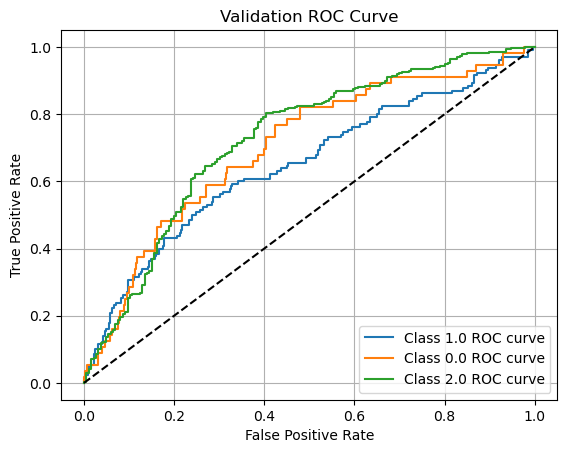

In [24]:

# ---------------------
# Step 3: Evaluate Model
# ---------------------
def evaluate_model(model, X, y, dataset_name="Validation"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    y_binarized_eval = label_binarize(y, classes=classes)

    print(f"\n--- {dataset_name} Performance ---")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision (macro):", precision_score(y, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y, y_pred, average='macro'))

    try:
        roc_auc = roc_auc_score(y_binarized_eval, y_proba, average='macro', multi_class='ovr')
        print("ROC AUC (macro):", roc_auc)
    except:
        print("ROC AUC not available for current setting.")

    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    #print("Confusion Matrix:")
    #print(confusion_matrix(y, y_pred))

    # Plot ROC Curve
    if y_binarized_eval.shape[1] == y_proba.shape[1]:  # only plot if same dimensions
        fpr = dict()
        tpr = dict()
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_binarized_eval[:, i], y_proba[:, i])

        plt.figure()
        for i in range(len(classes)):
            plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} ROC curve")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{dataset_name} ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

# Evaluate on validation and test sets
evaluate_model(best_model, X_val, y_val, "Validation")


--- Test Performance ---
Accuracy: 0.6206140350877193
Precision (macro): 0.5172267117066677
Recall (macro): 0.4267513739512094
F1 Score (macro): 0.42737493320179226
ROC AUC (macro): 0.6926430779650777

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.12      0.19        56
         1.0       0.45      0.25      0.32       131
         2.0       0.66      0.90      0.76       269

    accuracy                           0.62       456
   macro avg       0.52      0.43      0.43       456
weighted avg       0.57      0.62      0.57       456



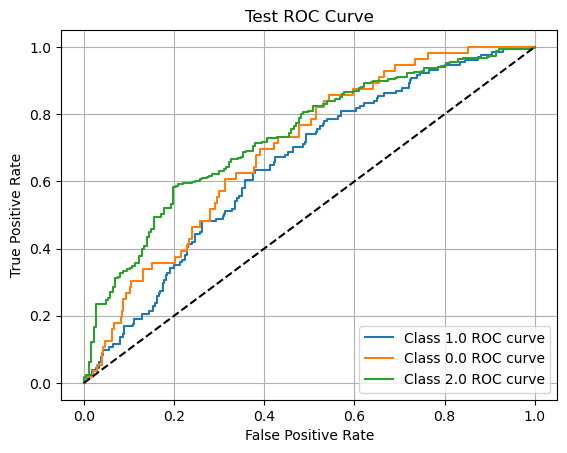

In [25]:
evaluate_model(best_model, X_test, y_test, "Test")

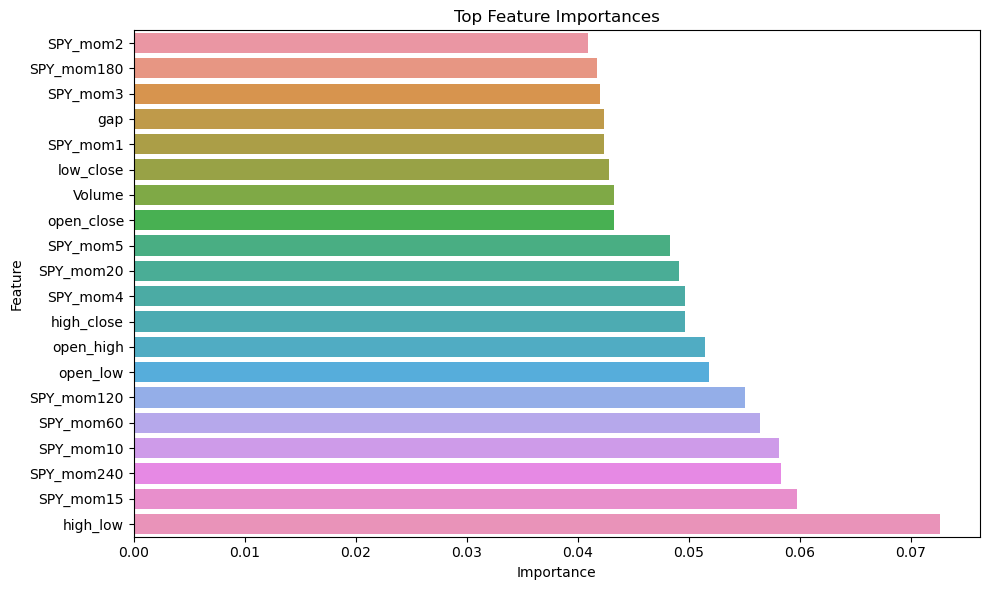

In [ ]:
# Feature importance plot
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title("Top Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model, X.columns)

In [34]:
os.getcwd()
dat = date.today().strftime('%Y-%m-%d')

In [35]:

directory = os.getcwd()

# Save the model
joblib.dump(best_model, f"{directory}/rf_models/rf_NFEAT{len(cols)}_{dat}.pkl")

# To load the model later:
# model = joblib.load("random_forest_multiclass_model.pkl")

['c:\\Users\\User\\Documents\\ATS_Development\\Strat_1/rf_models/rf_NFEAT22_2025-04-21.pkl']

In [32]:
len(cols)

22